# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim  # TensorFlow-Slim
from sklearn.model_selection import train_test_split

from io import BytesIO
from zipfile import ZipFile
import requests
import os
import time
import math
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

In [5]:
# Constants
NUMBER_OF_CLASSES = 43
IMAGE_SIZE = 32
NUMBER_OF_CHANNELS = 3

IMAGE_NORMALIZE1 = False
IMAGE_NORMALIZE2 = False
IMAGE_HISTOGRAM_NORMALIZE = False
IMAGE_MEAN_NORMALIZE = True

EPOCHS = 50 #100
BATCH_SIZE = 128
BATCH_SIZE_INF = 2048
VALIDATION_SIZE = 0.2

LEARNING_RATE = 5e-3  # 0.0005 for ADAM - 5e-3 for plain gradient descent
DROPOUT_KEEP = 0.5  #0.25

MODEL_SAVE_PATH = "./model.ckpt"

RESTORE = False # restore a previously saved model (no training)

### Download traffic sign dataset

In [6]:
def download_if_not_existing(file_url):
    if not os.path.isfile("data/test.p") or not os.path.isfile("data/train.p"):
        url = requests.get(file_url)
        zipfile = ZipFile(BytesIO(url.content))
        zipfile.extractall(path="data")
        print("data files downloaded and extracted")
    else:
        print("data file exist")

In [7]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
%time download_if_not_existing("https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip")

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

data file exist
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 152 µs
X_train shape: (39209, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [8]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Visualise some traffic sign images from the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

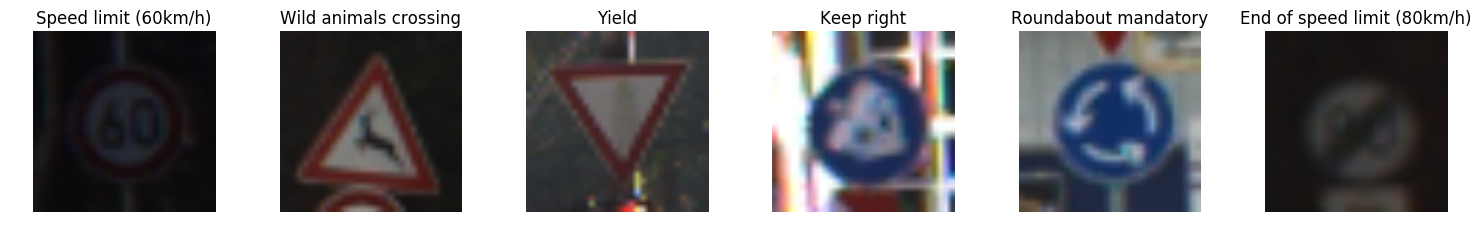

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Read the sign names into a numpy array (note first row is col headings)
# By setting dtype to None, genfromtxt will try to automatically work
# out the data types - however for strings it gives byte sequences so 
# we convert them to strings when needed.
signnames = np.genfromtxt("signnames.csv", delimiter=",", dtype=None)

# Pick a random sample of the training images
num_images_to_show = 6
indices = np.random.randint(0, n_train, num_images_to_show)
images = X_train[indices]
labels = y_train[indices]

plt.rcParams["figure.figsize"] = [15, 5]
plt.axis("off")  # clear x- and y-axes

for i, image in enumerate(images):
    plt.subplot(1, num_images_to_show, i+1)
    plt.axis("off")  # clear x- and y-axes
    plt.imshow(image)
    label_idx = labels[i]
    plt.title(signnames[label_idx+1][1].decode("utf-8"))
    
plt.tight_layout()

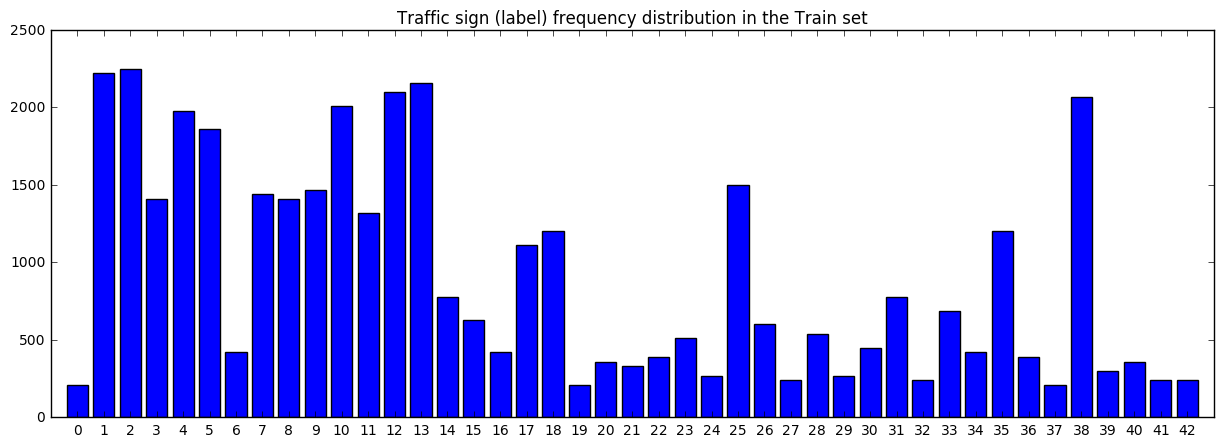

In [10]:
# Plot a bar chart of the label counts
# np.unique -> Returns the sorted unique elements of an array
labels, counts = np.unique(y_train, return_counts=True)

plt.figure()
axes = plt.gca()
axes.set_xlim([-1,43])
plt.bar(labels, counts, tick_label=labels, width=0.8, align="center")
plt.title("Traffic sign (label) frequency distribution in the Train set")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Pre-processing and train/validation/test split

In [11]:
def normalize(f):
    """
    Intensity min-max normalization
    """
    lmin = float(f.min())
    lmax = float(f.max())
    return np.floor((f - lmin) / (lmax - lmin) * 255.)

In [12]:
def equalize(f):
    """
    Histogram normalization
    """
    h = np.histogram(f, bins=np.arange(256))[0]
    H = np.cumsum(h) / float(np.sum(h))
    e = np.floor(H[f.flatten().astype("int")-1] * 255.)
    return e.reshape(f.shape)

In [13]:
def mean_normalization(X):
    lmin = float(X.min())
    lmax = float(X.max())
    return (X - np.mean(X)) / (lmax-lmin)

In [14]:
def preprocess(X, y):
    """
    Preprocess image data, and convert labels into one-hot
    """
    # Convert from RGB to grayscale if applicable
    #if GRAYSCALE:
    #    X = rgb_to_gray(X)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    X = X.astype("float32")
    
    if IMAGE_NORMALIZE1:
        print("Normalizing image data between 1 and -1")
        X = (X - 128.) / 128.
    if IMAGE_NORMALIZE2:
        print("Intensity normalizing images processed")
        X = normalize(X)
    if IMAGE_HISTOGRAM_NORMALIZE:
        print("Histogram normalisation processed")
        X = equalize(X)
    if IMAGE_MEAN_NORMALIZE:
        print("Image mean normalisation processed")
        X = mean_normalization(X)
    

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUMBER_OF_CLASSES))
    #y = np.eye(NUMBER_OF_CLASSES)[y_onehot.astype(int)]
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot

    return X, y

In [15]:
X_train, y_train = preprocess(X_train, y_train)
X_test, y_test = preprocess(X_test, y_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

print("Train, Validation & Test data ready")

Image mean normalisation processed
Image mean normalisation processed
Train, Validation & Test data ready


### Iteration generator for mini-batches

In [16]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
        
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield inputs[excerpt], targets[excerpt]

### Calculate and return accuracy with TF operations

In [17]:
def calculate_accuracy(inputs, targets, batch_size, accuracy, x, y, keep_prob, sess):
    """
    Helper function to calculate accuracy on a given dataset - averaging over the batch size.
    """
    data_size = inputs.shape[0]
    num_batches = math.ceil(data_size / batch_size)
    last_batch_size = data_size % batch_size

    accs = []  # accuracy for each batch
    
    for batch in iterate_minibatches(inputs, targets, batch_size, shuffle=True):
        images, labels = batch
            
        # Perform forward pass and calculate accuracy
        # Note we set keep_prob to 1.0, since we are performing inference
        acc = sess.run(accuracy, feed_dict={x: images, y: labels, keep_prob: 1.})
        accs.append(acc)
        
    # Calculate average accuracy of all full batches (the last batch is the only partial batch)
    acc_full = np.mean(accs[:-1])
    
    # Calculate weighted average of accuracy accross batches
    acc = (acc_full * (data_size - last_batch_size) + accs[-1] * last_batch_size) / data_size
    
    return acc

### Build TF network architecture (using tf-slim helpers)

In [18]:
def inference():
    with tf.variable_scope("neural_network"):
        # Tensors representing input images and labels
        with tf.name_scope("input"):
            x = tf.placeholder("float", [None, IMAGE_SIZE, IMAGE_SIZE, NUMBER_OF_CHANNELS], name="images-input")
            y = tf.placeholder("float", [None, NUMBER_OF_CLASSES], name="labels-input")
            # Placeholder for dropout keep probability
            keep_prob = tf.placeholder(tf.float32, name="Dropout")

        # Use batch normalization for all convolution layers
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            # Given x shape is (32, 32, 3)
            # Conv and pool layers
            n = slim.conv2d(x, 16, [3, 3], scope="conv_1")  # output shape: (32, 32, 16)
            n = slim.max_pool2d(n, [3, 3], 1, padding="SAME", scope="pool_1")  # output shape: (32, 32, 16)
            n = slim.conv2d(n, 64, [5, 5], 3, padding="VALID", scope="conv_2")  # output shape: (10, 10, 64)
            n = slim.max_pool2d(n, [3, 3], 1, scope="pool_2")  # output shape: (8, 8, 64)
            n = slim.conv2d(n, 128, [3, 3], scope="conv_3")  # output shape: (8, 8, 128)
            n = slim.max_pool2d(n, [3, 3], 1, scope="pool_3")  # output shape: (6, 6, 64)
            n = slim.conv2d(n, 256, [3, 3], scope="conv_4")  # output shape: (8, 8, 64)
            n = slim.max_pool2d(n, [3, 3], 1, scope="pool_4")  # output shape: (6, 6, 64)

            # Final fully-connected layers
            n = tf.contrib.layers.flatten(n)
            n = slim.fully_connected(n, 1024, scope="fully_conneted_1")
            with tf.name_scope("dropout_1"):
                n = tf.nn.dropout(n, keep_prob)
            n = slim.fully_connected(n, 1024, scope="fully_connect_2")
            with tf.name_scope("dropout_2"):
                n = tf.nn.dropout(n, keep_prob)
            n = slim.fully_connected(n, NUMBER_OF_CLASSES, scope="fully_connected_3")

        # Final output - Logits
        logits = n

        # Loss (data loss and regularization loss) and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
        #optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
        
        # Prediction (used during inference)
        predictions = tf.argmax(logits, 1)

        # Accuracy metric calculation
        correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Return relevant tensor references
    return x, y, keep_prob, logits, optimizer, predictions, accuracy

In [19]:
print("Current settings:")
print("NUMBER_OF_CLASSES:", NUMBER_OF_CLASSES)
print("IMAGE_SIZE:", IMAGE_SIZE)
print("NUMBER_OF_CHANNELS:", NUMBER_OF_CHANNELS)

print("\nIMAGE_NORMALIZE1:", IMAGE_NORMALIZE1)
print("IMAGE_NORMALIZE2:", IMAGE_NORMALIZE2)
print("IMAGE_HISTOGRAM_NORMALIZE:", IMAGE_HISTOGRAM_NORMALIZE)
print("IMAGE_MEAN_NORMALIZE:", IMAGE_MEAN_NORMALIZE)

print("\nEPOCHS:", EPOCHS)
print("BATCH_SIZE:", BATCH_SIZE)
print("BATCH_SIZE_INF:", BATCH_SIZE_INF)
print("VALIDATION_SIZE:", VALIDATION_SIZE)
print("LEARNING_RATE:", LEARNING_RATE)
print("DROPOUT_KEEP:", DROPOUT_KEEP)

print("\nMODEL_SAVE_PATH:", MODEL_SAVE_PATH)
print("RESTORE:", RESTORE)

Current settings:
NUMBER_OF_CLASSES: 43
IMAGE_SIZE: 32
NUMBER_OF_CHANNELS: 3

IMAGE_NORMALIZE1: False
IMAGE_NORMALIZE2: False
IMAGE_HISTOGRAM_NORMALIZE: False
IMAGE_MEAN_NORMALIZE: True

EPOCHS: 50
BATCH_SIZE: 128
BATCH_SIZE_INF: 2048
VALIDATION_SIZE: 0.2
LEARNING_RATE: 0.005
DROPOUT_KEEP: 0.5

MODEL_SAVE_PATH: ./model.ckpt
RESTORE: False


In [20]:
def save_model(saver, accuracy_history, sess):
    """
    Save model and accuracy data to disk (TF checkpoint)
    """
    save_path = saver.save(sess, MODEL_SAVE_PATH)
    print("Trained model saved at:", save_path)
    
    with open("accuracy_history.p", "wb") as f:
        pickle.dump(accuracy_history, f)

### Train the network or load saved parameters

In [21]:
def train():
    """
    Perform inference (build the model) and train on the train dataset using
    stochastic gradient descent with minibatches; saving results to a file
    for later use.
    """
    # Launch the graph
    with tf.Graph().as_default(), tf.Session() as sess:
        x, y, keep_prob, logits, optimizer, predictions, accuracy = inference()
        saver = tf.train.Saver()

        if RESTORE:
            print("Restoring previously trained model at %s" % MODEL_SAVE_PATH)
            saver.restore(sess, MODEL_SAVE_PATH)

            # Restore previous accuracy history
            with open('accuracy_history.p', 'rb') as f:
                accuracy_history = pickle.load(f)

            return accuracy_history
        
        else:
            print('Training model...')
            init = tf.global_variables_initializer()
            sess.run(init)

            # For plotting purposes we keep track of the training and validation accuracies
            accuracy_history = []

        # Timing
        last_time = time.time()
        train_start_time = time.time()

        # Run EPOCHS epochs of training
        for epoch in range(EPOCHS):
            
            # Run training on each BATCH_SIZE minibatch
            for (images, labels) in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
                sess.run(optimizer, feed_dict={x: images, y: labels, keep_prob: DROPOUT_KEEP})

            # Average accuracy over training set
            train_acc = calculate_accuracy(X_train, y_train, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
            
            # Average accuracy over validation set
            valid_acc = calculate_accuracy(X_valid, y_valid, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
                        
            # Record and report train/validation/test accuracies for this epoch
            accuracy_history.append((train_acc, valid_acc))

            print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Elapsed time: %.2f sec' %\
                (epoch+1, train_acc, valid_acc, time.time() - last_time))
            last_time = time.time()
            

        total_time = time.time() - train_start_time
        print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time / 60))

        # After training is complete, evaluate accuracy on test set
        print("\nCalculating test accuracy...")
        test_accuracy = calculate_accuracy(X_test, y_test, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
        print("\nTest accuracy: %.4f" % (test_accuracy))

        save_model(saver, accuracy_history, sess)
                
    return accuracy_history
                
accuracy_history = train()

Training model...
Epoch 1 -- Train acc.: 0.4719, Validation acc.: 0.4732, Elapsed time: 24.04 sec
Epoch 2 -- Train acc.: 0.6368, Validation acc.: 0.6311, Elapsed time: 20.49 sec
Epoch 3 -- Train acc.: 0.7984, Validation acc.: 0.7934, Elapsed time: 20.47 sec
Epoch 4 -- Train acc.: 0.8441, Validation acc.: 0.8374, Elapsed time: 20.51 sec
Epoch 5 -- Train acc.: 0.9049, Validation acc.: 0.8945, Elapsed time: 20.45 sec
Epoch 6 -- Train acc.: 0.9428, Validation acc.: 0.9369, Elapsed time: 20.53 sec
Epoch 7 -- Train acc.: 0.9239, Validation acc.: 0.9140, Elapsed time: 20.47 sec
Epoch 8 -- Train acc.: 0.9674, Validation acc.: 0.9612, Elapsed time: 20.49 sec
Epoch 9 -- Train acc.: 0.9775, Validation acc.: 0.9737, Elapsed time: 20.44 sec
Epoch 10 -- Train acc.: 0.9674, Validation acc.: 0.9610, Elapsed time: 20.49 sec
Epoch 11 -- Train acc.: 0.9852, Validation acc.: 0.9799, Elapsed time: 20.44 sec
Epoch 12 -- Train acc.: 0.9885, Validation acc.: 0.9841, Elapsed time: 20.48 sec
Epoch 13 -- Train a

##### Calculate the test accuracy - handy for when the model has been restored:

In [26]:
# This assumes that the model has been previously run above...
# I use this just to see what the test accuracy was if I've restored the model.
print("\nCalculating test accuracy...")
with tf.Graph().as_default(), tf.Session() as sess:
    # Instantiate the model
    x, y, keep_prob, logits_op, optimizer_op, predictions_op, accuracy_op = inference()

    # Load trained weights
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH)
    
    test_accuracy = calculate_accuracy(X_test, y_test, BATCH_SIZE_INF, accuracy_op, x, y, keep_prob, sess)
    print("\nTest accuracy: %.4f" % (test_accuracy))


Calculating test accuracy...

Test accuracy: 0.9524


### Plot the training and validation accuracies

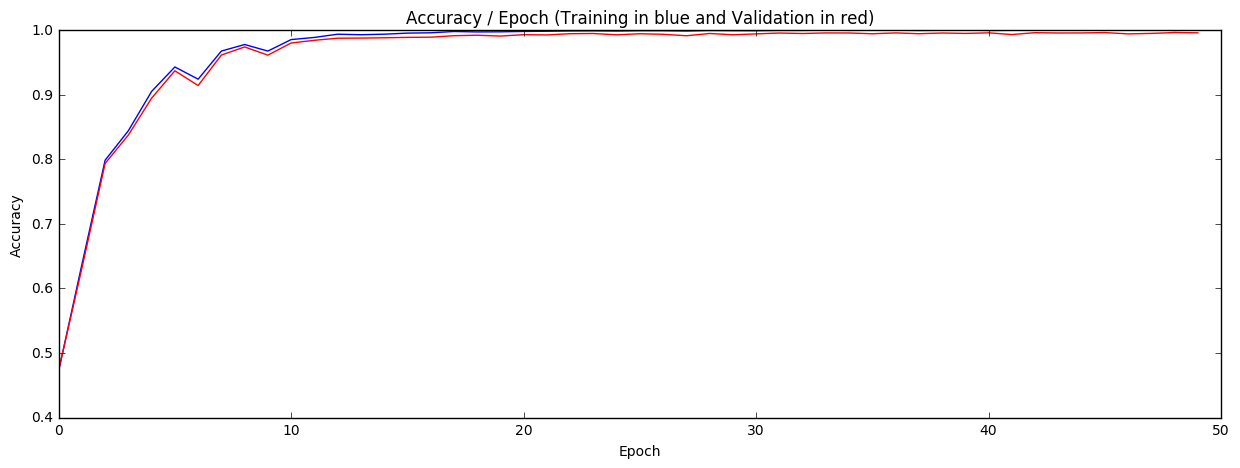

In [27]:
# Accuracy history has been saved as a List of Tuples
# Convert to numpy array - shape is (EPOCHS x 2)
# To plot this we transpose so that EPOCHS will be along X-axis

hist = np.transpose(np.array(accuracy_history))
plt.plot(hist[0], "b")  # training accuracy
plt.plot(hist[1], "r")  # validation accuracy
plt.title("Accuracy / Epoch (Training in blue and Validation in red)")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Hyperparameter manual grid-search

#### Test adding more layers (deeper network)
Add another conv layer doubly deep as the previous layer:<br>
Validation acc.: 0.9960 after 50 epochs!!!! Ended up only getting Test accuracy: 0.9535 after 100 epochs so its overfitting!<br><br>

Add another FC layer without dropout:<br>
Test accuracy: 0.9683<br><br>


### Test with image normalization
0.9554 with no norm<br>
0.9546 with 1 - -1 norm<br>
0.9459 with norm 2<br>
0.9492 with both intensity norm and histo norm.<br>
0.9538 with mean norm<br>
##### Basically no real difference with this dataset!



Test accuracy 0.9602<br>
EPOCHS: 40<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>
With batch shuffling seems to make no difference just randomly bubbles around 0.95 to 0.96!

Changing dropout_keep to 0.75 makes no difference! At 0.25 its slower to train so lets increase epochs and see???

#### WE HAVE A NEW WINNER with dropout of 0.25:<br>
Test accuracy: 0.9718<br>
EPOCHS: 100<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.25<br>

Without normalising the pixel values between -1 and 1 makes for a slight decrease in performance to 0.9678. Probably not statistically significant.



#### The rest of the tests...
Any batches after about 40 seem to be a waste of time for the below test!



Test accuracy 0.9538<br>
EPOCHS: 100<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>

##### BEST

Test acc.: 0.9624<br>
EPOCHS: 30<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.005<br>
DROPOUT_KEEP: 0.5<br>

Based on this more than 40 epochs is a waste at current settings is a waste - might pay to implement early stopping.

Changed to ADAM optimier but accuracy levels are terrible - need to change all params!

Test accuracy: 0.9351
EPOCHS: 30<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0001<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: 0.9467
EPOCHS: 50<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0001<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: 0.9530<br>
EPOCHS: 50<br>
BATCH_SIZE: 128<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0005<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: 0.9570<br>
EPOCHS: 40<br>
BATCH_SIZE: 256<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0005<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: 0.9515<br>
EPOCHS: 50<br>
BATCH_SIZE: 512<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0005<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: 0.9450<br>
EPOCHS: 50<br>
BATCH_SIZE: 1024<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0005<br>
DROPOUT_KEEP: 0.5<br>

Test accuracy: VERY BAD !<br>
EPOCHS: 50<br>
BATCH_SIZE: 64<br>
BATCH_SIZE_INF: 2048<br>
VALIDATION_SIZE: 0.2<br>
LEARNING_RATE: 0.0005<br>
DROPOUT_KEEP: 0.5<br>

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

I tested a variety of pre-processing options, including: max-min normalisation; histogram normalisation; mean normalisation; grayscale and didn't see a realistic benefit with this dataset. I ended up going with just mean normalisation due to a weight of evidence for its benefit online.

Maybe when running over longer cycles (epochs) and different network parameters, normalisation benefits may have become more apparent. I limited all my test runs to a maximum of 100 epochs due to the amount of time taken (even when running on an AWS GPU using the carnd image); though I performed most tests with normalisation at only 15 epochs.

I have used the sklearn train_test_split() function to split out the test set further into a validation and test set.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I use sklearn train_test_split() function to break up the test dataset (by proportion: VALIDATION_SIZE) into a validation and test dataset.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the standard SGD optimizer to train the model. I tried to use the Adam optimizer which internally uses momentum, learning rate decreasing, etc but failed to get it to match the SGD optimizer.<br>
Initially ADAM gave meaningless reuslts until I adjusted the learning rate down by an order of magnitude (around 0.0001).

The best results I could get were between 0.9450 and 0.9457 with ADAM, whereas with the standard SGD optimizer I could easily achiever better than this over various learning rater, batch sizes and epochs.

I imagine that the ADAM results would be better with more complex networks and larger datasets.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started by modifying the Lenet implementation from the course to work with our image sizes and adjusted from their based on the tensorflow examples (on tensorflow.org).

I then effectively performed a manual grid search over the hyperparamters, optimization routine (between SGD and ADAM) and image normlaistion. I have left some of the result from this in the notebook above. Mainly from changing the learnign rate more than anything else.

Quite early on I discounted the ADAM optimizer - it was very fussy with parameters and I couldn't seem to get it to beat the SGD results.

From research I came across artices talking about a trend of using larger batch sizes with lots of epochs so I ramped up the batch size but didn't really see a benefit and settles on 128.

I also played with the dropout (keep) figure and interestingly found that by decresasing this (i.e. making the dropout more severe) I got better test set results! I had to make a corresponding increase to the number of epochs as it slowed down the learning rate. I settled on 100 epochs in the end. From about 90 onwards there will little change in the result. Any more than tht just took too damn long for someone like me who is time-constrained this xmas period!
I settled on a dropout keep amount of 25%.

So to sum up - most of my findings were by trial and error and educated guesses.

One thing that I found the most difficult was tensorflow itself. Underastanding the summaries and checkpoints was like black magic and I gave up trying to use tensorboard - instead I just store an array or my accuracy per epoch for graphing.

My frustrations with the low-level tensorflow library consumed me... After reading this google blog post: https://research.googleblog.com/2016/08/tf-slim-high-level-library-to-define.html I switched to using tensoflow slim. Tensoflorw-slim is what Google's engineers used to built the Inception-V3 model so it must be pretty good. It just removes the tedium of creating all the intermeditate TF variables and keeping track of the weights and so on...



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [28]:
def convert_image_files_in_dir(dir):
    """
    Use the Pillow Image object to read and resize images in the
    specified directory - converting them to numpy arrays for ML
    processing.
    """
    image_list = []
    
    for file in os.listdir(dir):
        image = Image.open(dir + "/" + file)
        image = image.convert("RGB")
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
        image = np.array(list(image.getdata()), dtype="uint8")
        image = np.reshape(image, (32, 32, 3))
        image_list.append(image)

    return np.array(image_list, dtype="uint8")

### Load sample images (from Australian road signs) and display a random sample

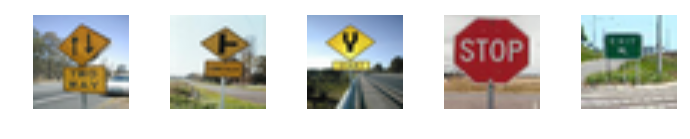

In [30]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_images = convert_image_files_in_dir("traffic_signs_au")
num_images_to_show = 5
indices = np.random.randint(0, len(test_images), num_images_to_show)
images_to_show = test_images[indices]

plt.rcParams["figure.figsize"] = [7, 4]
plt.axis("off")  # clear x- and y-axes

for i, test_image in enumerate(images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.axis("off")  # clear x- and y-axes
    plt.imshow(test_image)
    
plt.tight_layout()

### Run the model on the random sample of test images and display the predictions

Image mean normalisation processed

Predictions on test images:


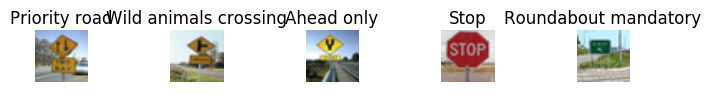

In [32]:
dummy_labels = np.array([0 for _ in range(images_to_show.shape[0])])
images_to_show_preprocessed, _ = preprocess(images_to_show, dummy_labels)

with tf.Graph().as_default(), tf.Session() as sess:
    # Instantiate the model
    x, y, keep_prob, logits_op, optimizer_op, predictions_op, accuracy_op = inference()

    # Load trained weights
    saver = tf.train.Saver()
    saver.restore(sess, MODEL_SAVE_PATH)
    
    logits, predictions = sess.run([logits_op, predictions_op], feed_dict={x: images_to_show_preprocessed, keep_prob: 1.})

final_preds = [signnames[p+1][1].decode("utf-8") for p in predictions]

# Print predictions on my sample images
print("\nPredictions on test images:")

plt.figure()
plt.rcParams["figure.figsize"] = [7, 4]
plt.axis("off")

for i, test_image in enumerate(images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.axis("off")
    plt.imshow(test_image)
    plt.title(final_preds[i])
    
plt.tight_layout()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Graph().as_default(), tf.Session() as sess:
    logits_placeholder = tf.placeholder("float", [None, NUMBER_OF_CLASSES])
    softmax = tf.nn.softmax(logits_placeholder)
    top_k, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    # Run the session to calculate the top_k softmax values using the logits tensor calculated
    # from our predictions run above.
    top_k_values, top_k_indexes = sess.run([top_k, top_k_idx], feed_dict={logits_placeholder: logits})
    
    plt.figure()
    #plt.rcParams["figure.figsize"] = [25, 10]
        
    for i, test_image in enumerate(images_to_show):
        top_k_predictions = [signnames[i+1][1] for i in top_k_indexes[i]]
        #print(top_k_predictions)
        prediction_string = ""
        for j in range(5):
            image_predictions = top_k_predictions[j].decode("utf-8"), top_k_values[i][j]
            #if j == 0:
            #    prediction_string = "%s %s" % (image_predictions[0], image_predictions[1])
            #else:
            prediction_string += "\n%s %s" % (image_predictions[0], image_predictions[1])
            #print(j, image_predictions)
            #print(image_predictions[0], image_predictions[1])
        
        plt.subplot(1, num_images_to_show, i+1)
        plt.axis("off")
        plt.imshow(test_image)
        plt.title(prediction_string)

As can be seen above, the performance on Australian traffic signs is pretty woeful even though we are getting around 97% accuracy on the German traffic sign test set. The reasons for this is suspect are that the meaning of the objects can be quite different in Australia and we even have speed limit signs that Germans don't have such as the 75km/h sign which is recognised as the German 70km/h sign.
Interestingly the model is able to pick out arrows to suggest things like "keep left" even though it doesn't match the Australian meaning.

So, for an internation version of an autonomous vehicle we either need a worldwide signs training set or we have specific models for each country.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.